<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [48]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics.pairwise import linear_kernel
# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
df=pd.read_csv("../data/datos.csv",index_col=0)
df = df.fillna(" ").reset_index(drop = True)
datam=df.copy()
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido

In [50]:
# Consolidar todas las reseñas de un producto en una sola
data = datam.groupby('productName').agg({
    'reviewText': ' '.join,  # Concatenar reseñas
    "reviewStar":'mean',
    'mainDepartment': 'first',  # Mantener un departamento único
    'subDepartment': 'first'  # Mantener un subdepartamento único
}).reset_index()
data[data["subDepartment"]=="Computers & Tablets"]

,productName,reviewText,reviewStar,mainDepartment,subDepartment
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",The laptop arrived just in time for school!! W...,3.049180,Computers,Computers & Tablets
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Bought for school work. Doing good so far.Slee...,2.932331,Computers,Computers & Tablets
8,"Android 10.0 Tablet : MEBERRY 10"" Ultra-Fast 4...",Battery management said the last charge was 21...,2.000000,Computers,Computers & Tablets
38,"HP Chromebook 14-inch FHD Laptop, Intel Celero...",The computer arrived THREE DAYS before it was ...,3.826087,Computers,Computers & Tablets
47,"Lenovo Chromebook Flex 3 11"" Laptop, 11.6-Inch...",Got the Chromebook and was looking forward to ...,2.852941,Computers,Computers & Tablets
56,"Microsoft Surface Pro 7 – 12.3"" Touch-Screen -...",I may need to return to update this review. T...,2.750000,Computers,Computers & Tablets
69,SAMSUNG Galaxy Tab A 8.0-inch Android Tablet 6...,Didn't know it was a kids addition...but i.lik...,2.460000,Computers,Computers & Tablets
74,Samsung Galaxy Tab A7 10.4 Wi-Fi 32GB Silver (...,Not as easy to navigate as older models. Scree...,2.000000,Computers,Computers & Tablets


In [51]:
# Función para limpiar y preprocesar texto
# Cargar el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Definir la función para limpiar texto
def limpiar_texto_spacy(texto):
    """
    Limpia un texto eliminando contracciones, caracteres especiales, stopwords y tokenizando.
    Args:
    texto (str): Texto a limpiar.

    Returns:
    str: Texto limpio.
    """
    # Verificar si el texto es NaN o no es un string
    if not isinstance(texto, str):
        return ""
    
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())
    
    # Filtrar tokens: quitar stopwords, signos de puntuación y tokens no deseados
    palabras_limpias = [
        token.lemma_  # Usar el lema (forma base) de la palabra
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    
    # Unir las palabras filtradas en una sola cadena
    return " ".join(palabras_limpias)

# Crear una nueva columna con el texto preprocesado
data['cleaned_reviewText'] = data['reviewText'].apply(limpiar_texto_spacy)
data['cleaned_reviewText_and_subDepartment'] = data['subDepartment'] +" "+ data['cleaned_reviewText']

In [52]:
data.sample(5)


,productName,reviewText,reviewStar,mainDepartment,subDepartment,cleaned_reviewText,cleaned_reviewText_and_subDepartment
79,Seagate Portable 2TB External Hard Drive Porta...,This feels nothing like my other Seagate exter...,2.718519,Computers,Data Storage,feel like seagate external need large drive ri...,Data Storage feel like seagate external need l...
97,"livho 2 Pack Blue Light Blocking Glasses, Comp...",Got headaches with these glasses I like the an...,2.955224,Computers,Computer Accessories & Peripherals,get headache glass like antiglare feature miss...,Computer Accessories & Peripherals get headach...
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",I’ll admit I was very skeptical from reviews b...,2.912000,Electronics,CellPhones and Accessories,admit skeptical review decide purchase anyway ...,CellPhones and Accessories admit skeptical rev...
34,"Garmin DriveSmart 65, Built-In Voice-Controlle...",So far I have attempted to enter existing addr...,2.000000,Electronics,GPS and Navigation,far attempt enter exist address magellan gps s...,GPS and Navigation far attempt enter exist add...
63,Nintendo Joy-Con (L)/(R) Fortnite Fleet Force ...,dont do it these are cheap because some less t...,2.962121,Electronics,Video games and accessories,not cheap reputable character buy defective co...,Video games and accessories not cheap reputabl...


In [54]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_reviewText_and_subDepartment'])

In [55]:
# Convertir la matriz TF-IDF a un DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),  # Convertir la matriz sparse a un array denso
    columns=tfidf_vectorizer.get_feature_names_out()  # Obtener los nombres de las palabras
)

# Mostrar las primeras filas del DataFrame
tfidf_df.head()

,10,100,12,15,20,30,able,absolutely,accurate,actually,add,adjust,advertise,ago,air,allow,amazing,amazon,annoying,anymore,apart,app,appear,apple,apply,area,arm,arrive,ask,assemble,away,awesome,awful,bad,bag,ball,band,barely,base,battery,bed,begin,big,bike,bit,black,blink,blow,blue,bluetooth,bottle,box,brace,brand,break,bright,brush,bud,build,burn,button,buy,cable,camera,cap,card,care,carry,case,cause,chair,change,charge,cheap,check,clean,clear,click,clipper,close,coat,cologne,color,come,comfortable,company,compare,complaint,completely,computer,conditioner,connect,connection,consider,constantly,contact,control,controller,cool,cord,cost,couple,cover,crack,customer,cut,cute,daily,damage,dark,daughter,day,deal,decent,decide,defective,definitely,description,design,desk,device,die,difference,different,difficult,disappoint,disappointed,disappointing,download,drive,drop,dry,dryer,durable,ear,earbud,easily,easy,edge,end,especially,exactly,excellent,expect,expensive,experience,extra,extremely,eye,eyeliner,face,fact,fail,fairly,fall,fan,far,fast,feature,feel,figure,file,finally,fine,fit,fitbit,fix,flat,floor,foot,fragrance,free,fully,function,game,gaming,garmin,gb,gel,gift,glass,good,gps,great,guess,hair,half,hand,happen,happy,hard,hat,head,headphone,headset,hear,heat,heater,heavy,help,high,highly,hit,hold,hole,home,honestly,hope,horrible,hot,hour,house,hurt,husband,immediately,inch,include,inside,install,instead,instruction,internet,iphone,issue,item,job,key,keyboard,kid,kind,know,lantern,laptop,large,later,leak,leave,left,leg,let,level,life,light,lightweight,like,line,literally,little,live,lock,long,look,loose,lose,lot,loud,love,low,macbook,make,man,material,matter,mattress,maybe,mean,minute,miss,mode,model,money,month,morning,motion,mouse,multiple,music,nail,need,new,nice,night,noise,normal,notice,number,office,oil,ok,okay,old,open,option,order,original,outside,overall,pack,package,pad,pain,pair,past,pay,pc,people,perfect,perfectly,person,phone,pick,picture,piece,pillow,place,plastic,play,plug,plus,pocket,point,polish,poor,port,posture,power,pressure,pretty,price,pro,probably,problem,product,properly,protector,provide,pull,purchase,purpose,push,quality,quick,quickly,quiet,range,rate,razor,read,real,realize,reason,receive,recommend,record,refund,regular,remove,replace,replacement,reset,rest,result,return,review,right,rip,room,router,rug,run,samsung,save,say,scale,scent,scratch,screen,screw,second,seller,send,sensitive,service,set,setting,shampoo,sharp,shelf,shirt,shoe,short,shower,signal,simple,sit,size,skin,sleep,slide,slip,slow,small,smell,smooth,sock,soft,solid,son,soon,sound,space,speed,spend,spot,stand,star,start,state,stay,step,stick,stop,storage,store,strap,stretch,strong,stuff,sturdy,style,super,support,suppose,sure,surface,switch,tablet,tell,tent,terrible,test,thank,thing,think,throw,tight,tile,time,today,touch,towel,track,transfer,trip,try,turn,twice,type,uncomfortable,unfortunately,unit,update,usb,use,useless,user,usually,value,version,video,volume,wait,walk,wallet,want,warm,warranty,wash,waste,watch,water,waterproof,way,weak,wear,week,weight,white,wide,wife,wifi,window,wish,work,worth,wrist,write,wrong,year,yes
0,0.015173,0.027798,0.016459,0.011748,0.025410,0.004728,0.027408,0.000000,0.000000,0.011029,0.008828,0.000000,0.008828,0.000000,0.000000,0.000000,0.004620,0.026004,0.005277,0.000000,0.005486,0.013716,0.021107,0.069039,0.000000,0.004959,0.000000,0.032343,0.005874,0.0,0.004000,0.000000,0.000000,0.028681,0.000000,0.000000,0.00000,0.005020,0.000000,0.393247,0.00000,0.000000,0.003421,0.000000,0.003219,0.010164,0.000000,0.0,0.000000,0.000000,0.000000,0.020882,0.0,0.010692,0.007055,0.000000,0.000000,0.011921,0.010291,0.000000,0.035244,0.074264,0.014747,0.025143,0.000000,0.042624,0.000000,0.000000,0.025899,0.000000,0.0,0.011999,0.124552,0.006570,0.021380,0.004673,0.005345,0.000000,0.0,0.004567,0.009630,0.0,0.000000,0.069706,0.00521,0.014524,0.000000,0.000000,0.009239,0.000000,0.0,0.023833,0.000000,0.000000,0.013859,0.010291,0

In [56]:
tfidf_df.shape

(99, 500)

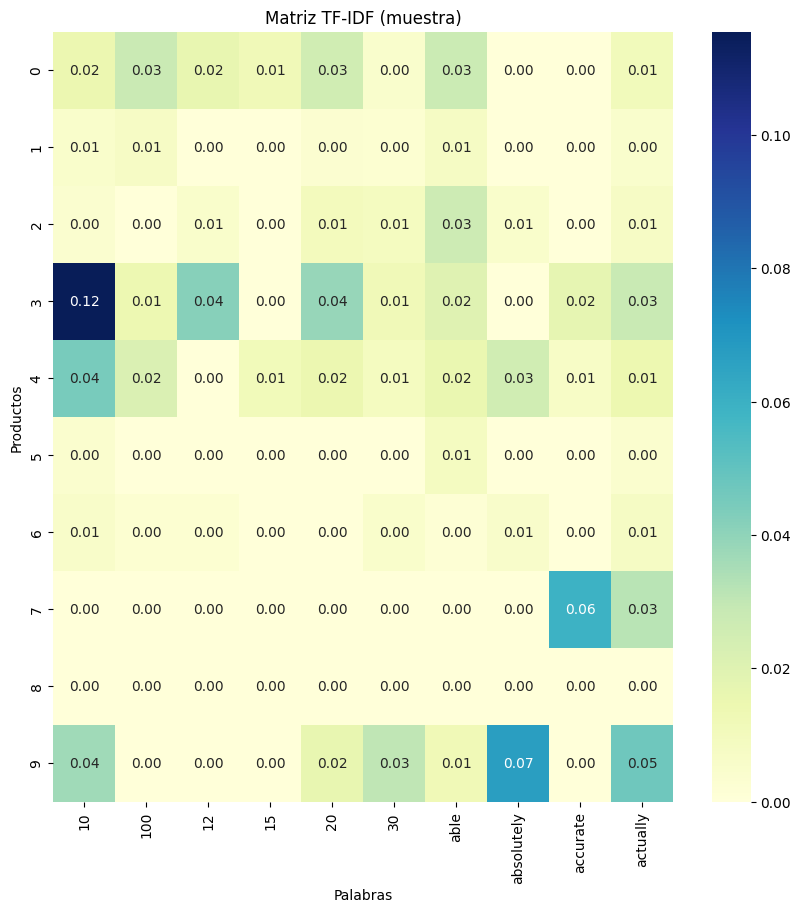

In [57]:
# Seleccionar una muestra de productos y palabras
sample_tfidf = tfidf_df.iloc[:10, :10]  # Los primeros 10 productos y 10 palabras

# Crear un mapa de calor
plt.figure(figsize=(10, 10))
sns.heatmap(sample_tfidf, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Matriz TF-IDF (muestra)")
plt.xlabel("Palabras")
plt.ylabel("Productos")
plt.show()

In [58]:
# Función para recomendar productos
def recommend_products_efficient(product_name, tfidf_matrix, data, top_n=5):
    """
    Recomienda productos similares de forma eficiente calculando similitudes solo cuando se soliciten,
    incluyendo el cociente de similitud.

    Args:
    - product_name (str): Nombre del producto base.
    - tfidf_matrix (csr_matrix): Matriz TF-IDF.
    - data (DataFrame): DataFrame con los datos originales.
    - top_n (int): Número de recomendaciones a devolver.

    Returns:
    - recomendaciones (DataFrame): DataFrame con los productos recomendados y sus puntuaciones de similitud.
    """
    # Buscar el índice del producto dado
    product_idx = data[data['productName'] == product_name].index[0]
    
    # Calcular similitudes solo para este producto
    cosine_similarities = linear_kernel(tfidf_matrix[product_idx], tfidf_matrix).flatten()
    
    # Ordenar los productos por puntuación de similitud
    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]
    similarity_scores = cosine_similarities[similar_indices]
    
    # Crear un DataFrame con las recomendaciones y sus puntuaciones de similitud
    recommendations = data.iloc[similar_indices][['productName', 'mainDepartment', 'subDepartment','reviewStar']].copy()
    recommendations['similarity'] = similarity_scores
    
    return recommendations


In [61]:
# Seleccionar un producto de ejemplo
example_product = data['productName'].iloc[30]

# Generar recomendaciones
recommendations = recommend_products_efficient(example_product, tfidf_matrix, data)

# Mostrar resultados
print(f"Producto base: {example_product}")
print("Recomendaciones similares:")
display(recommendations)


Producto base: Fruit of the Loom Men's Coolzone Boxer Briefs
Recomendaciones similares:


,productName,mainDepartment,subDepartment,reviewStar,similarity
48,Levi's Men's 505 Regular Fit Jeans,Computers,Men's Clothing,3.090909,0.737941
94,adidas Men's Adilette Shower Slide,Computers,Men's Shoes,3.127119,0.599924
20,Crocs Men's and Women's Classic Clog,Computers,Men's Shoes,2.769231,0.516002
35,"Gildan Men's Crew T-Shirts, Multipack",Computers,Men's Clothing,3.240000,0.421371
62,"Nike Unisex Adult OneSize Swoosh H86, Black/Me...",Computers,Men's Accessories,3.243902,0.345856


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 

In [ ]:
# Crear una nueva columna con el texto preprocesado
df['cleaned_reviewText'] = df['reviewText'].apply(limpiar_texto_spacy)
df.sample(5)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,cleaned_reviewText
5692,RGKXJRI3WXKDV,"Reviewed in the United States on November 20, ...",Electronics,GPS and Navigation,"Garmin 010-02064-00 Instinct, Rugged Outdoor W...",All fine except for the GPS accuracy,2.0,I must say that I am quite disappointed with t...,1,disappointed gps accuracy measured 10 mile run...
7880,R3B5MJYKPIO7SL,"Reviewed in the United States on August 25, 2020",Electronics,CellPhones and Accessories,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Fair condition,3.0,The phone was ok. I had a few issues but nothi...,0,phone ok issue major
7325,R2WPOX2EATGP1L,"Reviewed in the United States on August 14, 2021",Computers,Computers & Tablets,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Excellent product at a great price,5.0,This computer was a great purchase for my son....,0,computer great purchase son like play roblox m...
1270,R1BA5YWJY1JYC4,"Reviewed in the United States on July 16, 2020",Computers,Laptop Accessories,"havit HV-F2056 15.6""-17"" Laptop Cooler Cooling...",Good enough,4.0,Works well enough. Provides outer surface coo...,0,work provide outer surface cool well wife need...
6904,R3H1RTPP2FUFWX,"Reviewed in the United States on August 31, 2020",Sports and Outdoors,Outdoor Recreation,"Vont 2 Pack LED Camping Lantern, Super Bright ...",Found a better price without battery,2.0,Smaller than I though!,1,small


In [ ]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para clasificar sentimiento
def classify_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.45:
        return 'Positive'
    elif scores['compound'] < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Aplicar análisis de sentimientos
df['sentiment'] = df['cleaned_reviewText'].apply(classify_sentiment)

In [ ]:
# Resumen de distribución
print("Distribución de sentimientos:")
print(df['sentiment'].value_counts())

# Ejemplo de reseñas clasificadas
print("\nEjemplo de reseñas clasificadas:")
for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"\n{sentiment} Review Example:")
    print(df[df['sentiment'] == sentiment]['reviewText'].iloc[0])
    print(df[df['sentiment'] == sentiment]['reviewStar'].iloc[0])



Distribución de sentimientos:
sentiment
Positive    4586
Neutral     3943
Negative    1471
Name: count, dtype: int64

Ejemplo de reseñas clasificadas:

Positive Review Example:
Nice lightweight brace but unfortunately was too large for my wrist.  It is adjustable, but I guess I have a small wrist and it was way too big for me.  Did not offer enough support.
3.0

Negative Review Example:
Worked pretty well, but completely stopped working within 3 months of getting it. So that was disappointing. I’ve never had a space heater die on me like that :/
2.0

Neutral Review Example:
The color is completely different than hunter green and/or even what is in picture!!!
1.0


C:\Users\alexc\AppData\Local\Temp\ipykernel_9600\4113615120.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='reviewStar', palette='viridis')


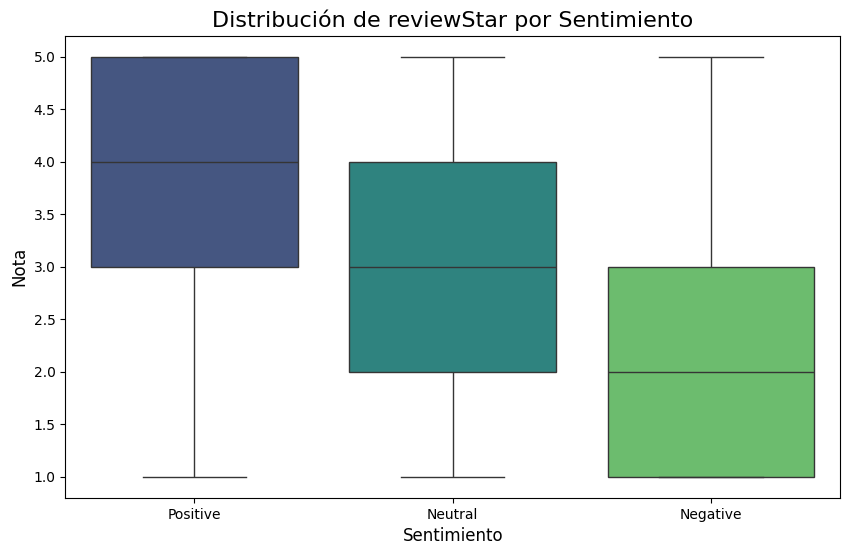

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Crear el boxplot
sns.boxplot(data=df, x='sentiment', y='reviewStar', palette='viridis')

# Personalizar el gráfico
plt.title('Distribución de reviewStar por Sentimiento', fontsize=16)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Nota', fontsize=12)

# Mostrar el gráfico
plt.show()

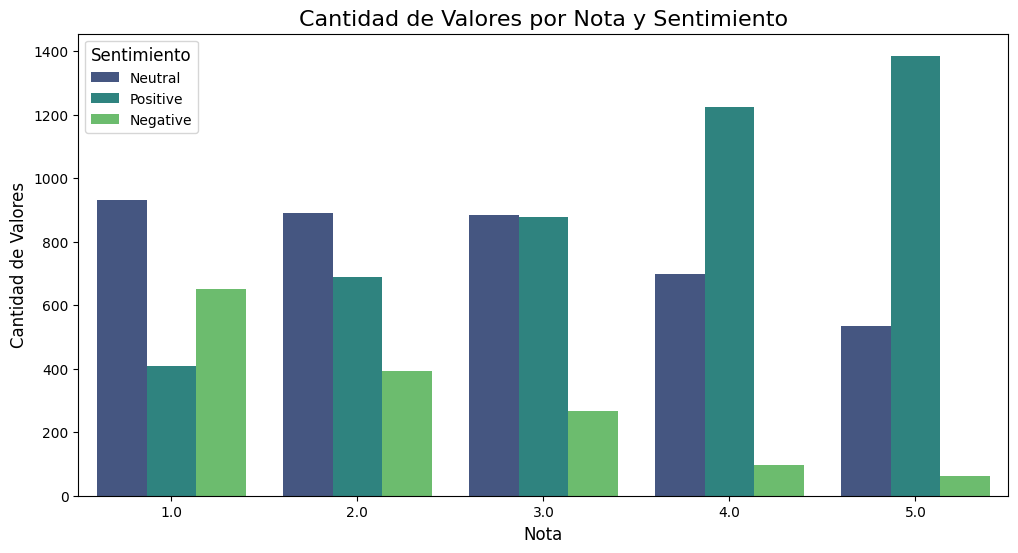

In [ ]:
# Crear el gráfico de barras agrupado
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='reviewStar', hue='sentiment', palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad de Valores por Nota y Sentimiento', fontsize=16)
plt.xlabel('Nota', fontsize=12)
plt.ylabel('Cantidad de Valores', fontsize=12)
plt.legend(title='Sentimiento', fontsize=10, title_fontsize=12)

# Mostrar el gráfico
plt.show()
